# Baseline Approaches

## Utilities and Imports

In [1]:
from platform import python_version
print('Python Version: {}'.format( python_version() ) )

# Utils
from tqdm import tqdm_notebook # Progress bar

import numpy as np
import matplotlib.pyplot as plt

import json
from   scipy.io import loadmat

# sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.neighbors     import NearestNeighbors


Python Version: 3.6.7


In [2]:
# Constants
RANDOM_STATE = 42

## Data Manipulation

### Load Data

In [3]:
with open( "PR_data/feature_data.json", "r" ) as file:
    features = json.load( file )
    
data = np.asarray( features )

print( 'Data shape: {}'.format( data.shape ) )

# Load matfile
mat = loadmat( 'PR_data/cuhk03_new_protocol_config_labeled.mat' )

# Load labels
labels = mat[ 'labels' ].flatten()

# Load camId
camIds = mat[ 'camId' ].flatten()

# Load indexes
train_idxs   = mat[ 'train_idx' ].flatten()
query_idxs    = mat[ 'query_idx' ].flatten()
gallery_idxs = mat[ 'gallery_idx' ].flatten()

# Load training indexes
print( "Loading Training indexes : {}".format( train_idxs.shape ) )
print( "Loading Query indexes : {}".format( query_idxs.shape ) )
print( "Loading Gallery indexes : {}".format( gallery_idxs.shape ) )

Data shape: (14096, 2048)
Loading Training indexes : (7368,)
Loading Query indexes : (1400,)
Loading Gallery indexes : (5328,)


### Create Train/Query/Gallery Sets

In [4]:
def generateSets():
    # Create Train Set
    train_set   = []
    train_label = []

    for i in train_idxs:
        train_set.append( data[ i - 1 ] )
        train_label.append( labels[ i - 1 ] )

    train_set   = np.asarray( train_set )
    train_label = np.asarray( train_label )

    print( 'Train Set : {}'.format( train_set.shape ) )
    print( 'Train Label : {}'.format( train_label.shape ) ) 

    # Create Query Set
    query_set   = []
    query_label = []
    query_camId = []

    for i in query_idxs:
        query_set.append( data[ i - 1] )
        query_label.append( labels[ i - 1 ] )
        query_camId.append( camIds[ i - 1 ] )

    query_set   = np.asarray( query_set )
    query_label = np.asarray( query_label )
    query_camId = np.asarray( query_camId )

    print( '\nQuery Set : {}'.format( query_set.shape ) )
    print( 'Query Label : {}'.format( query_label.shape ) )
    print( 'Query CamId : {}'.format( query_camId.shape ) )


    # Create Gallery Set
    gallery_set   = []
    gallery_label = []
    gallery_camId = []

    for i in gallery_idxs:
        gallery_set.append( data[ i - 1] )
        gallery_label.append( labels[ i - 1 ] )
        gallery_camId.append( camIds[ i - 1 ] )

    gallery_set   = np.asarray( gallery_set )
    gallery_label = np.asarray( gallery_label )
    gallery_camId = np.asarray( gallery_camId )

    print( '\nGallery Set : {}'.format( gallery_set.shape ) )
    print( 'Gallery Label : {}'.format( gallery_label.shape ) )
    print( 'Gallery CamId : {}'.format( gallery_camId.shape ) )
    
    return train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId
    
train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId = generateSets()

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


### Validation

* Pick 100 random identites from the training set
* Remove all data with those 100 identities from training set and put in validation set

There exists an idea in Computer Vision that you use validation set only to specify the number of iterations that is optimal for your design and then you include your validation set into train set and perform final training (without validation set) for this fixed amount of iterations. 

In [5]:
from sklearn.utils import shuffle

train_unique_labels = np.unique( train_label )

# Select 100 Random Identities
shuffled_validation_labels = shuffle( train_unique_labels, random_state = RANDOM_STATE )[ : 100 ] 
print( 'Selecting *{}* Random Identities For Validation Set'.format( shuffled_validation_labels.shape[ 0 ] ) )

train_validate = np.zeros( ( 1, 2049 ) )
train_set_validate_removed = np.vstack( ( train_set.T, train_label ) ).T

for identity in tqdm_notebook( shuffled_validation_labels ):
    
    # Go through data and remove rows with that identity
    validation = train_set_validate_removed[ np.where( train_set_validate_removed[ :, -1 ] == identity ) ]
    
    train_validate = np.vstack( ( train_validate, validation ) )
    
    train_set_validate_removed = train_set_validate_removed[ np.where( train_set_validate_removed[ :, -1 ] != identity )]
    
print( 'Training Set with Validation removed: {}'.format( train_set_validate_removed.shape ) )
print( 'Validation Set: {} ( Has an extra row due to np.zeros )'.format( train_validate.shape ) )

Selecting *100* Random Identities For Validation Set



Training Set with Validation removed: (6399, 2049)
Validation Set: (970, 2049) ( Has an extra row due to np.zeros )


In [6]:
cv_train_set   = train_set_validate_removed.T[ : -1 ].T
cv_train_label = train_set_validate_removed.T[ -1 : ].T

cv_validation_set = train_validate.T[ : -1 ].T[ 1: ]
cv_validation_label = train_validate.T[ -1 : ].T[ 1 : ]

print( 'CV Train Set: {} \nTrain Labels: {}'.format( cv_train_set.shape, cv_train_label.shape ) )
print( 'CV Validation Set: {} \nValidation Labels: {}'.format( cv_validation_set.shape, cv_validation_label.shape ) )


CV Train Set: (6399, 2048) 
Train Labels: (6399, 1)
CV Validation Set: (969, 2048) 
Validation Labels: (969, 1)


## Nearest Neighbor Baseline Approach

### Create Augmented Query And Gallery Sets

In [7]:
# Query Augmented
qs = query_set.T

query_augmented = np.vstack( ( qs, query_camId, query_label ) )
query_augmented = query_augmented.T

# Gallery Augmented
gs = gallery_set.T

gallery_augmented = np.vstack( ( gs, gallery_camId, gallery_label ) )
gallery_augmented = gallery_augmented.T

print( 'Query Augmented: {}'.format( query_augmented.shape ) )
print( 'Gallery Augmented: {}'.format( gallery_augmented.shape ) )

Query Augmented: (1400, 2050)
Gallery Augmented: (5328, 2050)


### Perform Baseline Nearest Neighbors

In [8]:
# KNN Parameters
knn_n_neighbors = 20
knn_metric = 'euclidean'

KNN = NearestNeighbors( n_neighbors = knn_n_neighbors, metric = knn_metric )
KNN.fit( gallery_augmented[ :, : -2 ], gallery_augmented[ :, -1 : ] )

query_rank_list = []
query_indices = []

# for i in range( 2,3 ):
for i in tqdm_notebook( range( query_augmented.shape[ 0 ] ) ):

    
    query_label = query_augmented[ i, -1 ].astype( int )

    # Test query point
    X_test = query_augmented[ i ][ : -2 ].reshape( 1, -1 ) # Remove last 2 columns ( camId and label )
    
    distances, indices = KNN.kneighbors( X_test ) # Neighbours are ordered closest to furthest
    
    # Compare
    distances = distances.flatten()
    indices   = indices.flatten()
    
    removed_indices = []
    
    # Remove indices with same camId and Row
    for ind in indices:
        if( ~( gallery_augmented[ ind, -1 ] == query_label and 
           gallery_augmented[ ind, -2 ] == query_augmented[ i, -2 ].astype( int ) ) ):
            
            removed_indices.append( ind )
    
    removed_indices = np.asarray( removed_indices )
    
    query_indices.append( removed_indices )
    
    rank_list = [ gallery_augmented[ ind, -1 ].astype( int ) == query_label for ind in removed_indices[ : 10 ] ]
    query_rank_list.append( rank_list )
    
query_rank_list = np.asarray( query_rank_list )
query_indices = np.asarray( query_indices )

#### Save Rank List

In [9]:
query_rank_list = query_rank_list.astype( int )

# Save as CSV so we dont have to fucking run that 20 minute code anymore
np.savetxt( 'query_rank_list.csv', query_rank_list, fmt='%i', delimiter= ',' )

#### Load Saved Rank List
* This avoids us having to rerun the baseline

In [10]:
# Load csv file
query_rank_list = np.loadtxt( 'query_rank_list.csv', delimiter = ',' )

### Nearest Neighbor Baseline Evaluation

#### Rank@ Scores

In [11]:
rankAt1  = query_rank_list.T[ 0 ]
rankAt2  = query_rank_list.T[ : 2 ].T
rankAt3 = query_rank_list.T[ : 3 ].T
rankAt4  = query_rank_list.T[ : 4 ].T
rankAt5 = query_rank_list.T[ : 5 ].T
rankAt6  = query_rank_list.T[ : 6 ].T
rankAt7  = query_rank_list.T[ : 7 ].T
rankAt8 = query_rank_list.T[ : 8 ].T
rankAt9  = query_rank_list.T[ : 9 ].T
rankAt10 = query_rank_list.T[ : 10 ].T

cmc1  = rankAt1
cmc2  = np.sum( rankAt2, axis = 1 ) > 0 
cmc3  = np.sum( rankAt3, axis = 1 ) > 0 
cmc4  = np.sum( rankAt4, axis = 1 ) > 0 
cmc5  = np.sum( rankAt5, axis = 1 ) > 0 
cmc6  = np.sum( rankAt6, axis = 1 ) > 0 
cmc7  = np.sum( rankAt7, axis = 1 ) > 0
cmc8  = np.sum( rankAt8, axis = 1 ) > 0 
cmc9  = np.sum( rankAt9, axis = 1 ) > 0 
cmc10 = np.sum( rankAt10, axis = 1 ) > 0

a11 = np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100
a21 = np.sum( cmc2 ) / cmc2.shape[ 0 ] * 100
a31 = np.sum( cmc3 ) / cmc3.shape[ 0 ] * 100
a41 = np.sum( cmc4 ) / cmc4.shape[ 0 ] * 100
a51 = np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100
a61 = np.sum( cmc6 ) / cmc6.shape[ 0 ] * 100
a71 = np.sum( cmc7 ) / cmc7.shape[ 0 ] * 100
a81 = np.sum( cmc8 ) / cmc8.shape[ 0 ] * 100
a91 = np.sum( cmc9 ) / cmc9.shape[ 0 ] * 100
a101 = np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100

print( 'rank@1: {}%'.format( np.sum( cmc1 ) / cmc1.shape[ 0 ] * 100 ) )
print( 'rank@2: {}%'.format( np.sum( cmc2 ) / cmc2.shape[ 0 ] * 100 ) )
print( 'rank@3: {}%'.format( np.sum( cmc3 ) / cmc3.shape[ 0 ] * 100 ) )
print( 'rank@4: {}%'.format( np.sum( cmc4 ) / cmc4.shape[ 0 ] * 100 ) )
print( 'rank@5: {}%'.format( np.sum( cmc5 ) / cmc5.shape[ 0 ] * 100 ) )
print( 'rank@6: {}%'.format( np.sum( cmc6 ) / cmc6.shape[ 0 ] * 100 ) )
print( 'rank@7: {}%'.format( np.sum( cmc7 ) / cmc7.shape[ 0 ] * 100 ) )
print( 'rank@8: {}%'.format( np.sum( cmc8 ) / cmc8.shape[ 0 ] * 100 ) )
print( 'rank@9: {}%'.format( np.sum( cmc9 ) / cmc9.shape[ 0 ] * 100 ) )
print( 'rank@10: {}%'.format( np.sum( cmc10 ) / cmc10.shape[ 0 ] * 100 ) )

Ranks = [ a11, a21, a31, a41, a51, a61, a71, a81, a91, a101 ]

rank@1: 47.0%
rank@2: 54.57142857142857%
rank@3: 59.64285714285714%
rank@4: 63.92857142857142%
rank@5: 66.85714285714286%
rank@6: 69.28571428571428%
rank@7: 71.14285714285714%
rank@8: 72.35714285714285%
rank@9: 73.71428571428571%
rank@10: 74.92857142857143%


#### Rank@ Accuracies

In [12]:
rank1Acc  = np.mean( np.mean( query_rank_list.T[ : 1 ], axis = 0 ) )
rank2Acc  = np.mean( np.mean( query_rank_list.T[ : 2 ], axis = 0 ) )
rank3Acc  = np.mean( np.mean( query_rank_list.T[ : 3 ], axis = 0 ) )
rank4Acc  = np.mean( np.mean( query_rank_list.T[ : 4 ], axis = 0 ) )
rank5Acc  = np.mean( np.mean( query_rank_list.T[ : 5 ], axis = 0 ) )
rank6Acc  = np.mean( np.mean( query_rank_list.T[ : 6 ], axis = 0 ) )
rank7Acc  = np.mean( np.mean( query_rank_list.T[ : 7 ], axis = 0 ) )
rank8Acc  = np.mean( np.mean( query_rank_list.T[ : 8 ], axis = 0 ) )
rank9Acc  = np.mean( np.mean( query_rank_list.T[ : 9 ], axis = 0 ) )
rank10Acc = np.mean( np.mean( query_rank_list.T[ : 10 ], axis = 0 ) )

Accuracies = [ rank1Acc, rank2Acc, rank3Acc, rank4Acc, rank5Acc, rank6Acc, rank7Acc, rank8Acc, rank9Acc, rank10Acc]
Accuracies = [ i * 100 for i in Accuracies ]

#### Accuracy Plot

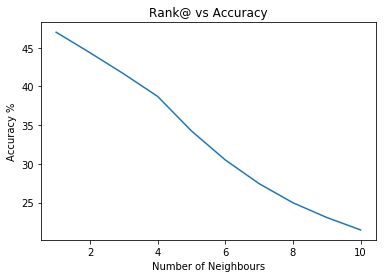

In [13]:
plt.plot( [ i for i in range( 1, 11 ) ], Accuracies )
plt.title( 'Rank@ vs Accuracy' )
plt.xlabel( 'Number of Neighbours' )
plt.ylabel( 'Accuracy %' )

plt.show()

#### mAP Score

In [16]:
average_precision=[]
for i in tqdm_notebook(range(len(query_rank_list))):
    Precision=[]
    Recall=[]
    Total=sum(query_rank_list[i,:])
    for j in range(1,query_rank_list.shape[1]+1):
        Precision.append(sum(query_rank_list[i,:j]/j))
        Recall.append(sum(query_rank_list[i,:j]/Total))
        if Recall[j-1] == 1:
            break

    indices=[]
    Recall=np.array(Recall)
    Recall = np.nan_to_num(Recall)
    Precision=np.array(Precision)

    #re-map the recall and position to 0.1 ... 1.0
    recall = np.arange(0.1,1.1,0.1)
    recall = np.asarray(recall)
    precision=[]

    for j in range(recall.size):
        for i in range(len(Recall)):
            if Recall[i] >= recall[j]:
                #interprelation of the data, finding the map between now and future
                precision.append(max(Precision[Recall.tolist().index(Recall[i]):len(Precision)]))
                break
    if np.sum(precision) == 0:
        average_precision.append(0)
    else:
        average_precision.append((np.sum(precision)+precision[0])/11)

average_precision = np.nan_to_num(average_precision)
baseline_map = np.mean(average_precision)
print( 'mAP: {}'.format( baseline_map ) )

/home/aufar/py_36_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  



mAP: 0.5169191146155432


## K Means Clustering Baseline

In [55]:
train_set, train_label, query_set, query_label, query_camId, gallery_set, gallery_label, gallery_camId = generateSets()

Train Set : (7368, 2048)
Train Label : (7368,)

Query Set : (1400, 2048)
Query Label : (1400,)
Query CamId : (1400,)

Gallery Set : (5328, 2048)
Gallery Label : (5328,)
Gallery CamId : (5328,)


In [7]:
from sklearn.cluster import KMeans
#size(n_samples, n_features)
kmeans = KMeans(n_clusters=np.size(np.unique(query_label)), random_state=0).fit(gallery_set)
kmeans.cluster_centers_
kmeans.predict
print(np.size(kmeans.labels_))
print(np.size(kmeans.cluster_centers_)/2048)
print(np.size(kmeans.cluster_centers_[110]))
predicted_class = kmeans.predict(query_set)
print(predicted_class.size)
# kmeans.labels_.tolist().index(101)
searchval = 0
ii = np.where(kmeans.labels_ == searchval)[0]
print(ii)


predicted_class = kmeans.predict(query_set)
# Query Augmented
qs = predicted_class.T
query_augmented = np.vstack( ( qs, query_camId, query_label ) )
query_augmented = query_augmented.T

qs = kmeans.labels_.T
gallery_augmented = np.vstack( ( qs, gallery_camId, gallery_label ) )
gallery_augmented = gallery_augmented.T

query_rank_list_kmean = []

# for i in range( 2,4 ):
for i in tqdm_notebook(range(predicted_class.shape[0])): 
    
    ii = np.where(kmeans.labels_ == predicted_class[i])[0]
    for j in ii:
        if (gallery_augmented[j,1] != query_augmented[i,1]):
            query_rank_list_kmean.append(gallery_augmented[j,2] == query_augmented[i,2])  
    
query_rank_list_kmean = np.asarray( query_rank_list_kmean )

print(sum(query_rank_list_kmean)/query_rank_list_kmean.shape[0])

5328
700.0
2048
1400
[3060 4419]



0.5247208931419458
